In [7]:
import torch as th
import torch.nn as nn
import torch.nn.init as init
import pandas as pd
import numpy as np
import os
seed = 1787

class Network():
    def dist_mat(self, x):
        try:
            x = th.from_numpy(x)
        except TypeError:
            x = x

        if len(x.size()) == 4:
            x = x.view(x.size()[0], -1)
        dist = th.norm(x[:, None] - x, dim=2)
        return dist

    def entropy(self, *args):
        for idx, val in enumerate(args):
            if idx == 0:
                k = val.clone()
            else:
                k *= val

        k /= k.trace()
        c = th.tensor([0])
        eigv = th.abs(th.linalg.eigvalsh(k, UPLO='U'))
        temp = eigv.clone()
        eigv_log2 = temp.log2()

        if (eigv == c).any():
            zero_indices = (eigv == 0).nonzero().tolist()
            small = th.tensor([0.0000000099])
            small_value = small.detach()
            for i in zero_indices:
                eigv_log2[i] = small_value

        if th.isnan(-((eigv * eigv_log2).sum())):
            if th.tensor(True) in th.isnan(eigv * (eigv_log2)):
                print('yesssssssssssssssssss')
                print(eigv)
                print(eigv_log2)
                print(eigv * (eigv_log2))
            else:
                print('nooooooooooooooooooo')
                print(eigv)

        return -(eigv * (eigv_log2)).sum()

    def kernel_mat(self, x, k_y, sigma=None, epoch=None):
        d = self.dist_mat(x)
        if sigma is None:
            if epoch > 20:
                sigma_vals = th.linspace(0.3, 10*d.mean(), 100)

            else:
                sigma_vals = th.linspace(0.3, 10*d.mean(), 300)
            L = []
            for sig in sigma_vals:
                k_l = th.exp(-d ** 2 / (sig ** 2)) / d.size(0)
                L.append(self.kernel_loss(k_y, k_l))

            if epoch == 0:
                self.sigmas[epoch] = sigma_vals[L.index(max(L))]
            else:
                self.sigmas[epoch] = 0.9*self.sigmas[epoch-1] + 0.1*sigma_vals[L.index(max(L))]
            sigma = self.sigmas[epoch]
        return th.exp(-d ** 2 / (sigma ** 2))

    def kernel_mat_training(self, x, k_y, sigma=None, epoch=None):
        d = self.dist_mat(x)
        if sigma is None:
            if epoch > 20:
                sigma_vals = th.linspace(0.3, 10*d.mean(), 100)

            else:
                sigma_vals = th.linspace(0.3, 10*d.mean(), 300)
            L = []
            for sig in sigma_vals:
                k_l = th.exp(-d ** 2 / (sig ** 2)) / d.size(0)
                L.append(self.kernel_loss(k_y, k_l))
            if epoch == 0:
                self.sigmas_training[epoch] = sigma_vals[L.index(max(L))]
            else:
                self.sigmas_training[epoch] = 0.9*self.sigmas_training[epoch-1] + 0.1*sigma_vals[L.index(max(L))]

            sigma = self.sigmas_training[ epoch]
        return th.exp(-d ** 2 / (sigma ** 2))

    def kernel_loss(self, k_y, k_l):
        beta = 1.0

        L = th.norm(k_l)
        Y = th.norm(k_y) ** beta

        LY = th.trace(th.matmul(k_l, k_y))**beta
        return 2*th.log2((LY)/(L*Y))

    def cal_mi(self, x, y, output, model, gpu, current_iteration):
        #model.eval()
        data= [output]
        data.insert(0, x)
        data.append(self.one_hot(y, gpu))

        k_x = self.kernel_mat(data[0], [], sigma=th.tensor(8.0))
        k_y = self.kernel_mat(data[-1], [],sigma=th.tensor(0.1))

        k_list = [k_x]
        for idx_l, val in enumerate(data[1:-1]):
            k_list.append(self.kernel_mat(val.reshape(data[0].size(0), -1),
                                          k_y, epoch=current_iteration))
        k_list.append(k_y)

        e_list = [self.entropy(i) for i in k_list]
        j_XT = [self.entropy(k_list[0], k_i) for k_i in k_list[1:-1]]
        j_TY = [self.entropy(k_i, k_list[-1]) for k_i in k_list[1:-1]]

        for idx_mi, val_mi in enumerate(e_list[1:-1]):
            self.MI[current_iteration, 0] = e_list[0]+val_mi-j_XT[idx_mi]
            self.MI[current_iteration, 1] = e_list[-1]+val_mi-j_TY[idx_mi]

        return

    def cal_mi_training(self, x, y, output, model, gpu, current_iteration):
        data= [output]
        data.insert(0, x)
        data.append(self.one_hot(y, gpu))

        k_x = self.kernel_mat_training(data[0], [], sigma=th.tensor(8.0))
        k_y = self.kernel_mat_training(data[-1], [],sigma=th.tensor(0.1))

        k_list = [k_x]

        for idx_l, val in enumerate(data[1:-1]):
            k_list.append(self.kernel_mat_training(val.reshape(data[0].size(0), -1),
                                           k_y, epoch=current_iteration))
        k_list.append(k_y)

        e_list = [self.entropy(i) for i in k_list]
        j_XT = [self.entropy(k_list[0], k_i) for k_i in k_list[1:-1]]
        j_TY = [self.entropy(k_i, k_list[-1]) for k_i in k_list[1:-1]]

        for idx_mi, val_mi in enumerate(e_list[1:-1]):
            self.MI_training[current_iteration, 0] = e_list[0]+val_mi-j_XT[idx_mi]
            self.MI_training[current_iteration, 1] = e_list[-1]+val_mi-j_TY[idx_mi]

        return

    def weight_init(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight.data)
            init.constant_(m.bias.data, 0)

    def one_hot(self, y, gpu):
        try:
            y = th.from_numpy(y)
        except TypeError:
            None

        y_1d = y
        if gpu:
            y_hot = th.zeros((y.size(0), th.max(y).int()+1)).cuda()
        else:
            y_hot = th.zeros((y.size(0), th.max(y).int()+1))

        for i in range(y.size(0)):
            y_hot[i, y_1d[i].int()] = 1

        return y_hot

In [ ]:
import random
import torch as th
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from matplotlib.ticker import PercentFormatter
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
import math
import os

seed = 1787
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
th.manual_seed(seed)
th.cuda.manual_seed(seed)
th.cuda.manual_seed_all(seed)
th.backends.cudnn.deterministic = True

gpu = th.cuda.is_available()

if gpu:
    th.cuda.set_device(0)
    device = th.device("cuda:0")
else:
    device = th.device("cpu")

class LeNet(nn.Module, Network):
    def __init__(self, n_iterations, n_iterations_training):
        nn.Module.__init__(self)

        self.sigmas = th.zeros((n_iterations))
        self.MI = th.zeros((n_iterations,2))
        self.sigmas_training = th.zeros((n_iterations_training))
        self.MI_training = th.zeros((n_iterations_training,2))
        self.test_accuracy = []
        self.train_accuracy = []
        self.train_loss = []
        self.test_loss = []

        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(50 * 4 * 4, 800)
        self.fc2 = nn.Linear(800, 500)
        self.fc3 = nn.Linear(500, 10)

        for m in self.modules():
            self.weight_init(m)

    def forward(self, x):
        layer1 = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        layer2 = F.max_pool2d(F.relu(self.conv2(layer1)), 2)
        layer2_p = layer2.view(-1, int(layer2.nelement() / layer2.shape[0]))
        layer3 = F.relu(self.fc1(layer2_p))
        layer4 = F.relu(self.fc2(layer3))
        layer5 = self.fc3(layer4)
        return layer5

N = 1
batch_size_tr = 100
batch_size_te = 100
epochs = 15
tr_size = 60000
te_size = 10000
mi_train_ratios = []
mi_test_ratios = []

n_iterations_per_epoch_training = (tr_size // batch_size_tr)
n_iterations_training = (tr_size // batch_size_tr) * epochs

n_iterations_per_epoch = (te_size // batch_size_te)
n_iterations = (te_size // batch_size_te) * epochs

# Datasets and Dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# transform = transforms.Compose(transforms.ToTensor())

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size_tr, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_te, shuffle=False)

print(f"Training on {'GPU' if device.type == 'cuda' else 'CPU'}")
model = LeNet(n_iterations, n_iterations_training).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# optimizer = th.optim.SGD(model.parameters(), lr=0.1,momentum=0.9)
# scheduler = MultiStepLR(optimizer, milestones=[60,40], gamma=0.1)

# optimizer = th.optim.SGD(model.parameters(), lr=0.001,momentum=0.9,weight_decay=1e-5)
# scheduler = MultiStepLR(optimizer, milestones=[20,30], gamma=0.1)

print(model.sigmas_training.shape)
criterion = nn.CrossEntropyLoss()

for n in range(N):
    mi_iteration = 0
    mi_iteration_training = 0

    for epoch in range(epochs):
        running_loss = 0
        train_acc = []

        for batch_num, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            model.train()
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            with th.no_grad():
                running_loss += loss.item()

                y_hat = th.argmax(output, 1)
                score = th.eq(y_hat, targets).sum()

                train_acc.append(score.item())
                model.cal_mi_training(inputs, targets, output, model, gpu, mi_iteration_training)
                mi_iteration_training += 1

        with th.no_grad():
            model.train_accuracy.append((sum(train_acc)*100)/tr_size)
            model.train_loss.append(running_loss/len(train_loader))
            test_acc = []
            test_loss = 0
            model.eval()
            for batch_nums, (inputs2, targets2) in enumerate(test_loader):
                inputs2 = inputs2.to(device)
                targets2 = targets2.to(device)
                output2 = model(inputs2)
                loss = criterion(output2, targets2)
                test_loss += loss.item()
                y_hat = th.argmax(output2, 1)
                score = th.eq(y_hat, targets2).sum()
                test_acc.append(score.item())

                model.cal_mi(inputs2, targets2, output2, model, gpu, mi_iteration)

                mi_iteration += 1

            model.test_accuracy.append((sum(test_acc)*100)/te_size)
            model.test_loss.append(test_loss/len(test_loader))

            MI_x_train = model.MI_training[epoch * n_iterations_per_epoch_training : (epoch+1)* n_iterations_per_epoch_training, 0]
            MI_x_train = np.mean(MI_x_train.cpu().detach().numpy().astype('float16')).round(decimals=3)

            MI_y_train = model.MI_training[epoch * n_iterations_per_epoch_training : (epoch+1)* n_iterations_per_epoch_training, 1]
            MI_y_train = np.mean(MI_y_train.cpu().detach().numpy().astype('float16')).round(decimals=3)

            MI_x = model.MI[epoch * n_iterations_per_epoch : (epoch+1)* n_iterations_per_epoch, 0]
            MI_x = np.mean(MI_x.cpu().detach().numpy().astype('float16')).round(decimals=3)

            MI_y = model.MI[epoch * n_iterations_per_epoch : (epoch+1)* n_iterations_per_epoch, 1]
            MI_y = np.mean(MI_y.cpu().detach().numpy().astype('float16')).round(decimals=3)

            # Calculate ΔI(X;T) and ΔI(T;Y) for training and testing data
            if epoch > 0:
                delta_train_x = MI_x_train - prev_MI_x_train
                delta_train_y = MI_y_train - prev_MI_y_train
                mi_train_ratio = delta_train_y / delta_train_x if delta_train_x != 0 else float('inf')
                mi_train_ratios.append(mi_train_ratio)
                print(f"Epoch {epoch + 1}/{epochs}, Train ΔI(X;T): {delta_train_x:.4f}, Train ΔI(T;Y): {delta_train_y:.4f}, Train Ratio: {mi_train_ratio:.4f}")

            # Store current MI values for next epoch's calculation
            prev_MI_x_train = MI_x_train
            prev_MI_y_train = MI_y_train

            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {model.train_loss[-1]:.4f}, Train Acc: {model.train_accuracy[-1]:.2f}%, Test Acc: {model.test_accuracy[-1]:.2f}%")
        scheduler.step()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15892959.26it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 486277.81it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3926743.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4489872.44it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training on CPU
torch.Size([9000])
Epoch 1/15, Train Loss: 0.2229, Train Acc: 95.04%, Test Acc: 98.16%
Epoch 2/15, Train ΔI(X;T): -0.2266, Train ΔI(T;Y): 0.0449, Train Ratio: -0.1982
Epoch 2/15, Train Loss: 0.0466, Train Acc: 98.57%, Test Acc: 98.69%
Epoch 3/15, Train ΔI(X;T): -0.0859, Train ΔI(T;Y): 0.0156, Train Ratio: -0.1818
Epoch 3/15, Train Loss: 0.0294, Train Acc: 99.11%, Test Acc: 98.72%
Epoch 4/15, Train ΔI(X;T): -0.0430, Train ΔI(T;Y): -0.0020, Train Ratio: 0.0454
Epoch 4/15, Train Loss: 0.0236, Train Acc: 99.20%, Test Acc: 98.89%
Epoch 5/15, Train ΔI(X;T): -0.0312, Train ΔI(T;Y): 0.0059, Train Ratio: -0.1875
Epoch 5/15, Train Loss: 0.0197, Train Acc: 99.33%, Test Acc: 99.05%
Epoch 6/15, Train ΔI(X;T): -0.0430, Train ΔI(T;Y): 0.0137, Train Ratio: -0.3181
Epoch 6/15, Train Loss: 0.0049, Train Acc: 99.85%, Test Acc: 99.28%
Epoch 7/15, Train ΔI(X;T): -0.0234, Train ΔI(T;Y): 0.0039, Train Ratio: -0.1666
Ep

Training on CPU
torch.Size([4800])
Epoch 1/8, Train Loss: 0.2229, Train Acc: 95.04%, Test Acc: 98.16%
Epoch 2/8, Train Loss: 0.0466, Train Acc: 98.57%, Test Acc: 98.69%, ΔI(T;Y)/ΔI(T;X):-0.1982
Epoch 3/8, Train Loss: 0.0294, Train Acc: 99.11%, Test Acc: 98.72%, ΔI(T;Y)/ΔI(T;X):-0.1818
Epoch 4/8, Train Loss: 0.0236, Train Acc: 99.20%, Test Acc: 98.89%, ΔI(T;Y)/ΔI(T;X):0.0454
Epoch 5/8, Train Loss: 0.0197, Train Acc: 99.33%, Test Acc: 99.05%, ΔI(T;Y)/ΔI(T;X):-0.1875
Epoch 6/8, Train Loss: 0.0049, Train Acc: 99.85%, Test Acc: 99.28%, ΔI(T;Y)/ΔI(T;X):-0.3181
Epoch 7/8, Train Loss: 0.0020, Train Acc: 99.96%, Test Acc: 99.26%, ΔI(T;Y)/ΔI(T;X):-0.1666
Epoch 8/8, Train Loss: 0.0011, Train Acc: 99.99%, Test Acc: 99.28%, ΔI(T;Y)/ΔI(T;X):-1.5000


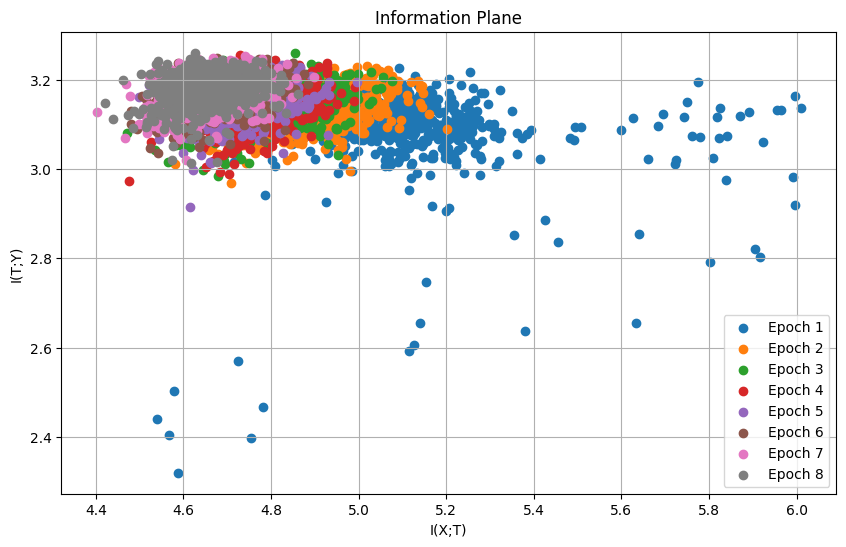

In [12]:
import random
import torch as th
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from matplotlib.ticker import PercentFormatter
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
import math
import os

seed = 1787
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
th.manual_seed(seed)
th.cuda.manual_seed(seed)
th.cuda.manual_seed_all(seed)
th.backends.cudnn.deterministic = True

gpu = th.cuda.is_available()

if gpu:
    th.cuda.set_device(0)
    device = th.device("cuda:0")
else:
    device = th.device("cpu")

class LeNet(nn.Module, Network):
    def __init__(self, n_iterations, n_iterations_training):
        nn.Module.__init__(self)

        self.sigmas = th.zeros((n_iterations))
        self.MI = th.zeros((n_iterations,2))
        self.sigmas_training = th.zeros((n_iterations_training))
        self.MI_training = th.zeros((n_iterations_training,2))
        self.test_accuracy = []
        self.train_accuracy = []
        self.train_loss = []
        self.test_loss = []

        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(50 * 4 * 4, 800)
        self.fc2 = nn.Linear(800, 500)
        self.fc3 = nn.Linear(500, 10)

        for m in self.modules():
            self.weight_init(m)

    def forward(self, x):
        layer1 = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        layer2 = F.max_pool2d(F.relu(self.conv2(layer1)), 2)
        layer2_p = layer2.view(-1, int(layer2.nelement() / layer2.shape[0]))
        layer3 = F.relu(self.fc1(layer2_p))
        layer4 = F.relu(self.fc2(layer3))
        layer5 = self.fc3(layer4)
        return layer5

N = 1
batch_size_tr = 100
batch_size_te = 100
epochs = 8
tr_size = 60000
te_size = 10000
mi_train_ratios = []
mi_test_ratios = []

n_iterations_per_epoch_training = (tr_size // batch_size_tr)
n_iterations_training = (tr_size // batch_size_tr) * epochs

n_iterations_per_epoch = (te_size // batch_size_te)
n_iterations = (te_size // batch_size_te) * epochs

# Datasets and Dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size_tr, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_te, shuffle=False)

print(f"Training on {'GPU' if device.type == 'cuda' else 'CPU'}")
model = LeNet(n_iterations, n_iterations_training).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print(model.sigmas_training.shape)
criterion = nn.CrossEntropyLoss()

for n in range(N):
    mi_iteration = 0
    mi_iteration_training = 0

    for epoch in range(epochs):
        running_loss = 0
        train_acc = []

        for batch_num, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            model.train()
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            with th.no_grad():
                running_loss += loss.item()

                y_hat = th.argmax(output, 1)
                score = th.eq(y_hat, targets).sum()

                train_acc.append(score.item())
                model.cal_mi_training(inputs, targets, output, model, gpu, mi_iteration_training)
                mi_iteration_training += 1

        with th.no_grad():
            model.train_accuracy.append((sum(train_acc)*100)/tr_size)
            model.train_loss.append(running_loss/len(train_loader))
            test_acc = []
            test_loss = 0
            model.eval()
            for batch_nums, (inputs2, targets2) in enumerate(test_loader):
                inputs2 = inputs2.to(device)
                targets2 = targets2.to(device)
                output2 = model(inputs2)
                loss = criterion(output2, targets2)
                test_loss += loss.item()
                y_hat = th.argmax(output2, 1)
                score = th.eq(y_hat, targets2).sum()
                test_acc.append(score.item())

                model.cal_mi(inputs2, targets2, output2, model, gpu, mi_iteration)

                mi_iteration += 1

            model.test_accuracy.append((sum(test_acc)*100)/te_size)
            model.test_loss.append(test_loss/len(test_loader))

            MI_x_train = model.MI_training[epoch * n_iterations_per_epoch_training : (epoch+1)* n_iterations_per_epoch_training, 0]
            MI_x_train = np.mean(MI_x_train.cpu().detach().numpy().astype('float16')).round(decimals=3)

            MI_y_train = model.MI_training[epoch * n_iterations_per_epoch_training : (epoch+1)* n_iterations_per_epoch_training, 1]
            MI_y_train = np.mean(MI_y_train.cpu().detach().numpy().astype('float16')).round(decimals=3)

            MI_x = model.MI[epoch * n_iterations_per_epoch : (epoch+1)* n_iterations_per_epoch, 0]
            MI_x = np.mean(MI_x.cpu().detach().numpy().astype('float16')).round(decimals=3)

            MI_y = model.MI[epoch * n_iterations_per_epoch : (epoch+1)* n_iterations_per_epoch, 1]
            MI_y = np.mean(MI_y.cpu().detach().numpy().astype('float16')).round(decimals=3)

            if (epoch==0):
              print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {model.train_loss[-1]:.4f}, Train Acc: {model.train_accuracy[-1]:.2f}%, Test Acc: {model.test_accuracy[-1]:.2f}%")

            # Calculate ΔI(X;T) and ΔI(T;Y) for training and testing data
            if epoch > 0:
                delta_train_x = MI_x_train - prev_MI_x_train
                delta_train_y = MI_y_train - prev_MI_y_train
                mi_train_ratio = delta_train_y / delta_train_x if delta_train_x != 0 else float('inf')
                mi_train_ratios.append(mi_train_ratio)

                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {model.train_loss[-1]:.4f}, Train Acc: {model.train_accuracy[-1]:.2f}%, Test Acc: {model.test_accuracy[-1]:.2f}%, ΔI(T;Y)/ΔI(T;X): {mi_train_ratio:.4f}")

            # Store current MI values for next epoch's calculation
            prev_MI_x_train = MI_x_train
            prev_MI_y_train = MI_y_train

        scheduler.step()

def plot_information_plane(model, epochs, n_iterations_per_epoch_training):
    MI_x_train = model.MI_training[:, 0].cpu().detach().numpy()
    MI_y_train = model.MI_training[:, 1].cpu().detach().numpy()
    plt.figure(figsize=(10, 6))
    for epoch in range(epochs):
        start_idx = epoch * n_iterations_per_epoch_training
        end_idx = (epoch + 1) * n_iterations_per_epoch_training
        plt.scatter(MI_x_train[start_idx:end_idx], MI_y_train[start_idx:end_idx], label=f'Epoch {epoch+1}')
    plt.xlabel('I(X;T)')
    plt.ylabel('I(T;Y)')
    plt.title('Information Plane')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Information Plane after training
plot_information_plane(model, epochs, n_iterations_per_epoch_training)


Training on CPU
torch.Size([9000])
Epoch 1/15, Train Loss: 0.9514, Train Acc: 78.28%, Test Acc: 92.14%
Epoch 2/15, Train Loss: 0.2282, Train Acc: 93.17%, Test Acc: 94.30%, ΔI(T;Y)/ΔI(T;X): 0.7812
Epoch 3/15, Train Loss: 0.1953, Train Acc: 94.27%, Test Acc: 94.99%, ΔI(T;Y)/ΔI(T;X): inf
Epoch 4/15, Train Loss: 0.1890, Train Acc: 94.31%, Test Acc: 94.57%, ΔI(T;Y)/ΔI(T;X): 0.3750
Epoch 5/15, Train Loss: 0.1726, Train Acc: 94.94%, Test Acc: 95.60%, ΔI(T;Y)/ΔI(T;X): -0.1000
Epoch 6/15, Train Loss: 0.1004, Train Acc: 96.96%, Test Acc: 96.98%, ΔI(T;Y)/ΔI(T;X): -0.3501
Epoch 7/15, Train Loss: 0.0835, Train Acc: 97.45%, Test Acc: 96.91%, ΔI(T;Y)/ΔI(T;X): 0.2142
Epoch 8/15, Train Loss: 0.0768, Train Acc: 97.70%, Test Acc: 96.99%, ΔI(T;Y)/ΔI(T;X): 0.3333
Epoch 9/15, Train Loss: 0.0711, Train Acc: 97.84%, Test Acc: 97.00%, ΔI(T;Y)/ΔI(T;X): 0.0000
Epoch 10/15, Train Loss: 0.0667, Train Acc: 97.93%, Test Acc: 97.10%, ΔI(T;Y)/ΔI(T;X): 0.0625
Epoch 11/15, Train Loss: 0.0555, Train Acc: 98.31%, Test Acc

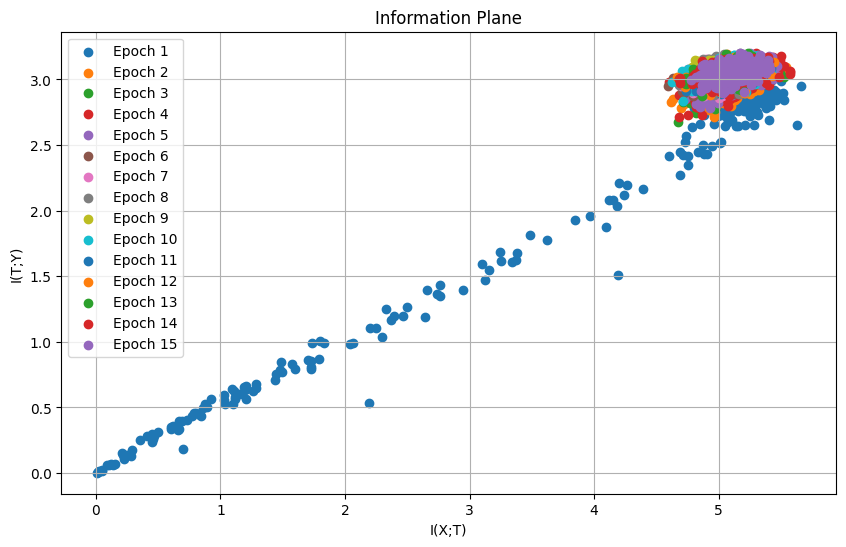

In [15]:
import random
import torch as th
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from matplotlib.ticker import PercentFormatter
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
import math
import os

seed = 1787
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
th.manual_seed(seed)
th.cuda.manual_seed(seed)
th.cuda.manual_seed_all(seed)
th.backends.cudnn.deterministic = True

gpu = th.cuda.is_available()

if gpu:
    th.cuda.set_device(0)
    device = th.device("cuda:0")
else:
    device = th.device("cpu")

class LeNet(nn.Module, Network):
    def __init__(self, n_iterations, n_iterations_training):
        nn.Module.__init__(self)

        self.sigmas = th.zeros((n_iterations))
        self.MI = th.zeros((n_iterations,2))
        self.sigmas_training = th.zeros((n_iterations_training))
        self.MI_training = th.zeros((n_iterations_training,2))
        self.test_accuracy = []
        self.train_accuracy = []
        self.train_loss = []
        self.test_loss = []

        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(50 * 4 * 4, 800)
        self.fc2 = nn.Linear(800, 500)
        self.fc3 = nn.Linear(500, 10)

        for m in self.modules():
            self.weight_init(m)

    def forward(self, x):
        layer1 = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        layer2 = F.max_pool2d(F.relu(self.conv2(layer1)), 2)
        layer2_p = layer2.view(-1, int(layer2.nelement() / layer2.shape[0]))
        layer3 = F.relu(self.fc1(layer2_p))
        layer4 = F.relu(self.fc2(layer3))
        layer5 = self.fc3(layer4)
        return layer5

N = 1
batch_size_tr = 100
batch_size_te = 100
epochs = 15
tr_size = 60000
te_size = 10000
mi_train_ratios = []
mi_test_ratios = []

n_iterations_per_epoch_training = (tr_size // batch_size_tr)
n_iterations_training = (tr_size // batch_size_tr) * epochs

n_iterations_per_epoch = (te_size // batch_size_te)
n_iterations = (te_size // batch_size_te) * epochs

# Datasets and Dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size_tr, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_te, shuffle=False)

print(f"Training on {'GPU' if device.type == 'cuda' else 'CPU'}")
model = LeNet(n_iterations, n_iterations_training).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print(model.sigmas_training.shape)
criterion = nn.CrossEntropyLoss()

for n in range(N):
    mi_iteration = 0
    mi_iteration_training = 0

    for epoch in range(epochs):
        running_loss = 0
        train_acc = []

        for batch_num, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            model.train()
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            with th.no_grad():
                running_loss += loss.item()

                y_hat = th.argmax(output, 1)
                score = th.eq(y_hat, targets).sum()

                train_acc.append(score.item())
                model.cal_mi_training(inputs, targets, output, model, gpu, mi_iteration_training)
                mi_iteration_training += 1

        with th.no_grad():
            model.train_accuracy.append((sum(train_acc)*100)/tr_size)
            model.train_loss.append(running_loss/len(train_loader))
            test_acc = []
            test_loss = 0
            model.eval()
            for batch_nums, (inputs2, targets2) in enumerate(test_loader):
                inputs2 = inputs2.to(device)
                targets2 = targets2.to(device)
                output2 = model(inputs2)
                loss = criterion(output2, targets2)
                test_loss += loss.item()
                y_hat = th.argmax(output2, 1)
                score = th.eq(y_hat, targets2).sum()
                test_acc.append(score.item())

                model.cal_mi(inputs2, targets2, output2, model, gpu, mi_iteration)

                mi_iteration += 1

            model.test_accuracy.append((sum(test_acc)*100)/te_size)
            model.test_loss.append(test_loss/len(test_loader))

            MI_x_train = model.MI_training[epoch * n_iterations_per_epoch_training : (epoch+1)* n_iterations_per_epoch_training, 0]
            MI_x_train = np.mean(MI_x_train.cpu().detach().numpy().astype('float16')).round(decimals=3)

            MI_y_train = model.MI_training[epoch * n_iterations_per_epoch_training : (epoch+1)* n_iterations_per_epoch_training, 1]
            MI_y_train = np.mean(MI_y_train.cpu().detach().numpy().astype('float16')).round(decimals=3)

            MI_x = model.MI[epoch * n_iterations_per_epoch : (epoch+1)* n_iterations_per_epoch, 0]
            MI_x = np.mean(MI_x.cpu().detach().numpy().astype('float16')).round(decimals=3)

            MI_y = model.MI[epoch * n_iterations_per_epoch : (epoch+1)* n_iterations_per_epoch, 1]
            MI_y = np.mean(MI_y.cpu().detach().numpy().astype('float16')).round(decimals=3)

            if (epoch==0):
              print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {model.train_loss[-1]:.4f}, Train Acc: {model.train_accuracy[-1]:.2f}%, Test Acc: {model.test_accuracy[-1]:.2f}%")

            # Calculate ΔI(X;T) and ΔI(T;Y) for training and testing data
            if epoch > 0:
                delta_train_x = MI_x_train - prev_MI_x_train
                delta_train_y = MI_y_train - prev_MI_y_train
                mi_train_ratio = delta_train_y / delta_train_x if delta_train_x != 0 else float('inf')
                mi_train_ratios.append(mi_train_ratio)

                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {model.train_loss[-1]:.4f}, Train Acc: {model.train_accuracy[-1]:.2f}%, Test Acc: {model.test_accuracy[-1]:.2f}%, ΔI(T;Y)/ΔI(T;X): {mi_train_ratio:.4f}")

            # Store current MI values for next epoch's calculation
            prev_MI_x_train = MI_x_train
            prev_MI_y_train = MI_y_train

        scheduler.step()

def plot_information_plane(model, epochs, n_iterations_per_epoch_training):
    MI_x_train = model.MI_training[:, 0].cpu().detach().numpy()
    MI_y_train = model.MI_training[:, 1].cpu().detach().numpy()
    plt.figure(figsize=(10, 6))
    for epoch in range(epochs):
        start_idx = epoch * n_iterations_per_epoch_training
        end_idx = (epoch + 1) * n_iterations_per_epoch_training
        plt.scatter(MI_x_train[start_idx:end_idx], MI_y_train[start_idx:end_idx], label=f'Epoch {epoch+1}')
    plt.xlabel('I(X;T)')
    plt.ylabel('I(T;Y)')
    plt.title('Information Plane')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Information Plane after training
plot_information_plane(model, epochs, n_iterations_per_epoch_training)
